In [59]:
import os
import json
import matplotlib.pyplot as plt

In [60]:
# Collect organizations and their co-occurences

orgs = []
texts = []
years = []
occurences = []

dir = 'json/'
files = os.listdir(dir)

for index, filename in enumerate(files):
    
    f = open(dir + filename)
    r = f.read()
    parsed = json.loads(r)
    
    # Set tags and remove excessive values

    tags = parsed[0]['story_tags']

    if len(tags) > 1000:
        continue

    # Set time

    try:
        year = int(parsed[0]['publish_date'].split(' ')[0].split('-')[0])
    except:
        continue

    # Collect organizations' names
    
    _names = []

    for tag in tags:
        if (tag['tag_set'] == 'cliff_organizations'):
            
            label = tag['tag']
            label = label.replace('.', '')
            
            if label.startswith('U.S. '): label = label.replace('U.S. ', '')
            if label.startswith('US '): label = label.replace('US ', '')
            
            if label == 'EU': label = 'European Union'
            # if label == 'E.U.': label = 'European Union'
            if label == 'IEA': label = 'International Energy Agency'
            if label == 'Exxon': label = 'ExxonMobil'
            if label == 'Exxon Mobil': label = 'ExxonMobil'
            if label == 'ExonnMobil': label = 'ExxonMobil'
            if label == 'US Energy Information Administration': label = 'Energy Information Administration'
            if label == 'Massachusetts Institute of Technology': label = 'MIT'
            # if label == 'U.N.': label = 'United Nations'
            if label == 'UN': label = 'United Nations'
            if label == 'EDF': label = 'Environmental Defense Fund'
            if label == 'Interior': label = 'Interior Department'
            if label == 'EIA': label = 'Energy Information Administration'
            if label == 'AP': label = 'Associated Press'
            if label == 'NOAA': label = 'National Oceanic and Atmospheric Administration'
            if label == 'US Forest Service': label = 'Forest Service'
            if label == 'US Department of Energy': label = 'Energy Department'
            if label == 'Energy Department': label = 'Department of Energy'
            if label == 'DOE': label = 'Department of Energy'
            if label == 'Energy': label = 'Department of Energy'
            if label == 'Agriculture': label = 'Department of Agriculture'
            if label == 'GE': label = 'General Electric'
            if label == 'Stanford': label = 'Stanford University'
            if label == 'NRDC': label = 'Natural Resources Defense Council'
            if label == 'EPA': label = 'Environmental Protection Agency'
            if label == 'Harvard': label = 'Harvard University'
            if label == 'house': label = 'House'
            if label == 'FDA': label = 'Food and Drug Administration'
            if label == 'GOP': label = 'Republican Party'
            if label == 'PG&E': label = 'Pacific Gas & Electric Co'
            if label == 'Xcel': label = 'Xcel Energy'
            if label == 'Penn State': label = 'Pennsylvania State University'
            if label == 'El Nino': label = 'El Niño'
            if label == 'SEC': label = 'Securities and Exchange Commission'
            if label == 'Sierra': label = 'Sierra Club'
            if label == 'PUC': label = 'Public Utilities Commission'

            stoplist = {'Elon Musk', 'Trump', 'CCS', 'green energy', 'clean energy'}
            
            if label not in stoplist:
                _names.append(label)

    # Collect by name

    # x -> years
    # y -> occurencies

    for n in _names:
        if n in orgs:
            
            index = orgs.index(n)
            texts[index] = texts[index] + _names
            occurences[index] += 1
            
            if year in years[index]:
                years[index][year] += 1
            else:
                years[index][year] = 1
                
        else:
            orgs.append(n)
            texts.append(_names)
            occurences.append(1)
            years.append({year: 1})


# Clean less citates organizations

for index, occurrence in reversed(list(enumerate(occurences))):

    min = 20

    if occurrence < min:
        orgs.pop(index)
        texts.pop(index)
        years.pop(index)
        occurences.pop(index)
    # else:
        # print()
        # print(index, occurrence, orgs[index])
        # print()

# order years by key in an array of tuples

for index, y in enumerate(years):
    sortedDict = dict( sorted(y.items(), key=lambda x: x[0]) )
    _temp = {}
    for k,v in sortedDict.items():
        _temp[k] = v
    years[index] = _temp

print(len(orgs), len(texts), len(years), len(occurences))

# print(texts[0])
# print(years[0][:, 0])



222 222 222 222


In [61]:
# Linear regression

import numpy as np
from sklearn.linear_model import LinearRegression

slopes = []
colors = []

for year in years:

    y = list(year.values())
    x = list(year.keys())

    print()
    print(x, y)

    x = np.array(x).reshape((-1, 1))
    
    model = LinearRegression().fit(x, y)
    slope = model.coef_
    score = model.score(x, y)
    print('slope', slope)
    print('score', score)

    slopes.append(slope)

    # Test with a gradient

    if slope > 0:
        colors.append('red')
    else:
        colors.append('blue')

    # if slope > .5:
    #     colors.append('red')
    # else:
    #     if slope > -.5:
    #         colors.append('orange')
    #     else:
    #         colors.append('blue')



# x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
# y = np.array([5, 20, 14, 32, 22, 38])

 [-0.3]
score 0.015286355979789112

[2011, 2013, 2014, 2015, 2016, 2017, 2018, 2020, 2021] [1, 1, 5, 5, 1, 7, 2, 2, 8]
slope [0.38219895]
score 0.20590792295356752

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] [3, 2, 3, 7, 2, 2, 1, 1, 6, 5]
slope [0.10909091]
score 0.02479338842975154

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] [3, 6, 2, 4, 1, 3, 6, 3, 2, 8]
slope [0.18181818]
score 0.06255212677230126

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] [12, 10, 8, 6, 9, 30, 11, 29, 22, 15, 7]
slope [0.77272727]
score 0.08795958120281766

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] [1, 3, 6, 2, 6, 4, 2, 17, 4, 14, 16]
slope [1.26363636]
score 0.4995087900723798

[2015, 2018, 2020, 2021] [2, 17, 3, 1]
slope [-0.4047619]
score 0.020149201701170516

[2011, 2012, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] [2, 1, 5, 3, 1, 2, 3, 1, 4, 3]
slope [0.07492507]
score 0.03405685223866761

[2011, 2012, 2013, 2014, 2015, 2

In [62]:
# Term Frequency Matrix

import textacy

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(texts, tf_type="linear", idf_type="smooth")

 * creating mesh with size 48 48
 * filling mesh


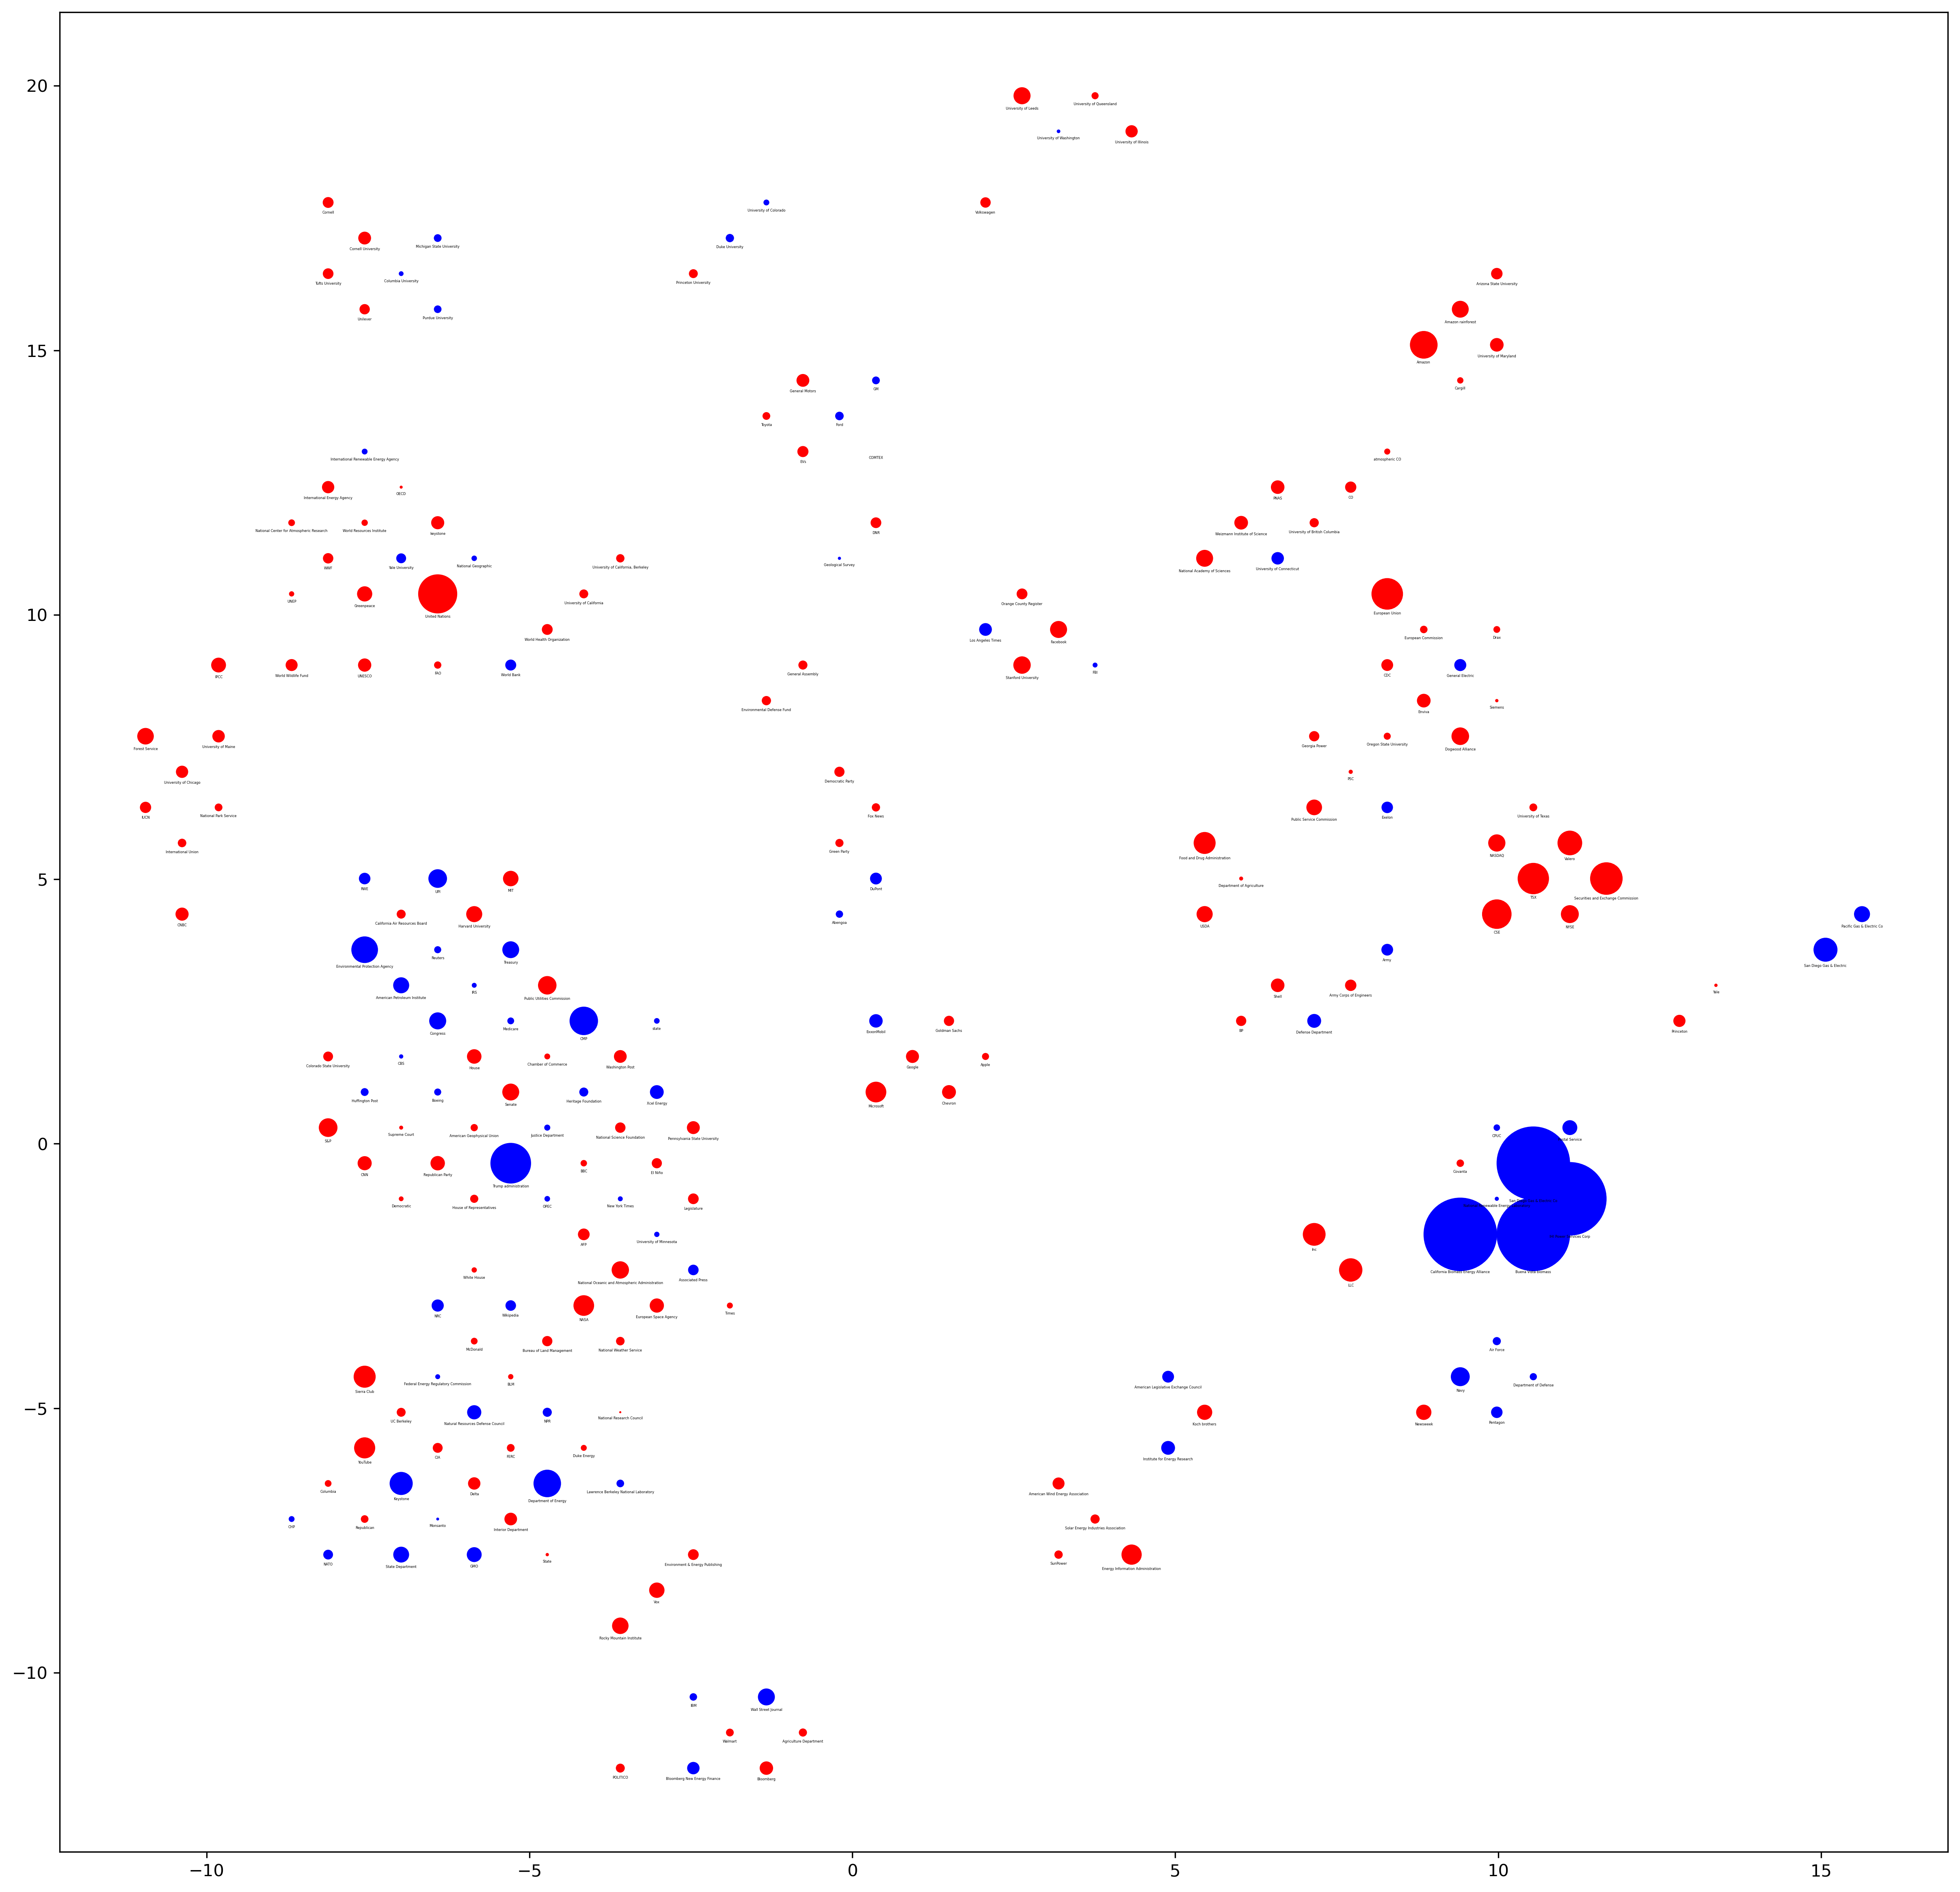

In [115]:
# UMAP

import umap
import math
import matplotlib.pyplot as plt
from pointgrid import align_points_to_grid


reducer = umap.UMAP(n_components=2, n_neighbors=2, min_dist=0.01, metric='cosine')
# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

for index, s in enumerate(slopes):
    slopes[index] = abs(s)*10

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=slopes, c=colors)

for i, txt in enumerate(orgs):
    text = plt.annotate(orgs[i], xy=(x[i], y[i] - math.sqrt(slopes[i]/math.pi)/40 - .15), ha='center', va='bottom')
    text.set_fontsize(2)

plt.savefig('/Users/dario/Desktop/download.png')
plt.savefig('download.png')